# NEON API exploration

In this file, I'll be exploring the NEON API using [this NEON API tutorial](https://www.neonscience.org/resources/learning-hub/tutorials/neon-api-01-introduction-requests) and NEON AOP HDF5 reflectance files using [this NEON AOP HDF5 tutorial](https://www.neonscience.org/resources/learning-hub/tutorials/neon-aop-hdf5-tile-py)

In [1]:
import requests # necessary for NEON API
import json

import numpy as np # necessary for exploring h5 files
import h5py
import osgeo.gdal, osgeo.osr, os
import matplotlib.pyplot as plt

from collections import namedtuple # for nicely organizing the many URLs and metadata
from itertools import chain # flattening a list when iterating very nested json info


In [2]:
# To request data, need to provide NEON's URL
SERVER = 'http://data.neonscience.org/api/v0/'

Some of the important endpoints for NEON are:
* _sites/_
* _products/_
* _data/_

In [3]:
# Define sites of interest
SITECODE_LIST = ['TEAK', 'SOAP', 'SJER']

# Make requests, then turn request data into a Python JSON object so it's easier to interact with
site_json_list = [requests.get(SERVER+'sites/'+SITECODE).json() 
                          for SITECODE in SITECODE_LIST]

In [4]:
# Display json info TEAK site
TEAK_json = site_json_list[0]
## TEAK_json ## super long output -- uncomment if you want to see

That was a huge dict...let's explore smaller parts and try to avoid listing the many dates

In [5]:
print(TEAK_json.keys(),'\n') # original dict only has 1 key -- 'data'

# look at info inside of 'data' key
NEON_dataDict_info = [str(key)+':\t'+str(type(TEAK_json['data'][key])) 
                          for key in TEAK_json['data'].keys()] 
print('\n'.join(NEON_dataDict_info), '\n')


# data products looked most interesting because I want to use that list to query products of interest
print('Exploring dataProducts')
dataProduct_Info = [str(type(product)) 
                        for product in TEAK_json['data']['dataProducts']] 
print('dataProducts contains a bunch of dicts...')
print(', '.join(dataProduct_Info), '\n')


print('What is in each of those dicts? They all have the same structure.')
dataProducts_ListOfDicts = TEAK_json['data']['dataProducts']
NEON_dataProducts_info = [str(subDict.keys())
                              for subDict in dataProducts_ListOfDicts][:3] ## just print the first few dataProducts_info
print('\n'.join(NEON_dataProducts_info), '\n') 


print('What are the data product codes and titles?')
NEON_dataProductCodes_info = [str(productDict['dataProductCode'])+'\t'+str(productDict['dataProductTitle'])
                                  for productDict in dataProducts_ListOfDicts] 
print('\n'.join(NEON_dataProductCodes_info), '\n')

dict_keys(['data']) 

siteCode:	<class 'str'>
siteName:	<class 'str'>
siteDescription:	<class 'str'>
siteType:	<class 'str'>
siteLatitude:	<class 'float'>
siteLongitude:	<class 'float'>
stateCode:	<class 'str'>
stateName:	<class 'str'>
domainCode:	<class 'str'>
domainName:	<class 'str'>
deimsId:	<class 'str'>
releases:	<class 'list'>
dataProducts:	<class 'list'> 

Exploring dataProducts
dataProducts contains a bunch of dicts...
<class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class 'dict'>, <class '

# Filtering URLs (for eventual download)

Using this information about the data available for my 3 sites of interest, I want to download data that meet the following specifications for each site:
* Data products:
    * Vegetation structure (DP1.10098.001)
    * Elevation - LiDAR (DP3.30024.001)
    * Spectrometer orthorectified surface directional reflectance - mosaic (DP3.30006.001)
* Most recent dataset

In [6]:
# Specifications
SERVER = 'http://data.neonscience.org/api/v0/'
SITES_LIST = ['TEAK', 'SOAP', 'SJER']
DATAPRODUCTS_DICT = {'Vegetation structure': 'DP1.10098.001', 
                     'Elevation - LiDAR': 'DP3.30024.001', 
                     'Spectrometer orthorectified surface directional reflectance - mosaic': 'DP3.30006.001'}

## Get a list of URLs for data to download ##

# get json info for my sites of interest
site_json_list = [requests.get(SERVER+'sites/'+site).json() 
                          for site in SITES_LIST]

# for each site, extract only the relevant dataproducts
dataprod_codes_list = list(DATAPRODUCTS_DICT.values())

def getProductsAtSite(site_json, dataprod_codes_list):
    return [site_dataProd_dict
            for site_dataProd_dict in site_json['data']['dataProducts']
            if site_dataProd_dict['dataProductCode'] in dataprod_codes_list
           ]

site_dataprod_dict = {site_json['data']['siteCode']:
                      getProductsAtSite(site_json, dataprod_codes_list)
                      for site_json in site_json_list}

## get the URL and only relevant metadata for only the most recent available datasets
# for each site, create a named tuple of tuples of the format below
productTupleNames = namedtuple('PRODUCT_METADATA', ['SITE','PRODUCT_TITLE', 'PRODUCT_CODE', 'DATE', 'URL'])

# for all products at all sites, get the metadata needed for our named productTuple
productTupleMetadata = list(chain(*[
    [(site,
      productD['dataProductTitle'],
      productD['dataProductCode'],
      productD['availableMonths'][-1],
      productD['availableDataUrls'][-1]
     )
     for productD in site_dataprod_dict[site]
    ]
    for site in site_dataprod_dict.keys()
]))

# the final named tuple with only our sites, products, and dates of interest
productTupleL=[productTupleNames(*productInfo)
               for productInfo in productTupleMetadata]

print(productTupleL)

[PRODUCT_METADATA(SITE='TEAK', PRODUCT_TITLE='Vegetation structure', PRODUCT_CODE='DP1.10098.001', DATE='2021-12', URL='https://data.neonscience.org/api/v0/data/DP1.10098.001/TEAK/2021-12'), PRODUCT_METADATA(SITE='TEAK', PRODUCT_TITLE='Spectrometer orthorectified surface directional reflectance - mosaic', PRODUCT_CODE='DP3.30006.001', DATE='2021-07', URL='https://data.neonscience.org/api/v0/data/DP3.30006.001/TEAK/2021-07'), PRODUCT_METADATA(SITE='TEAK', PRODUCT_TITLE='Elevation - LiDAR', PRODUCT_CODE='DP3.30024.001', DATE='2021-07', URL='https://data.neonscience.org/api/v0/data/DP3.30024.001/TEAK/2021-07'), PRODUCT_METADATA(SITE='SOAP', PRODUCT_TITLE='Vegetation structure', PRODUCT_CODE='DP1.10098.001', DATE='2022-01', URL='https://data.neonscience.org/api/v0/data/DP1.10098.001/SOAP/2022-01'), PRODUCT_METADATA(SITE='SOAP', PRODUCT_TITLE='Spectrometer orthorectified surface directional reflectance - mosaic', PRODUCT_CODE='DP3.30006.001', DATE='2021-07', URL='https://data.neonscience.or

In [7]:
# exploring the files to download from each URL
for product_metadata in productTupleL:
    # make request with saved url
    data_request = requests.get(product_metadata.URL)
    data_json = data_request.json()
    
    # print info on the files we can access for this particular site and product
    print(product_metadata.SITE, '\t|', product_metadata.PRODUCT_TITLE)
    print('\n'.join(set([' '.join(fileD['name'].replace('.','_').split('_')[6:]) # the first 6 info slots are redundant 
                     for fileD in data_json['data']['files']]) # for clarity, I used set to remove duplicate printouts -- but there are LOTS of h5 files
                   ),
         '\n\n')

TEAK 	| Vegetation structure
readme 20220711T220416Z txt
vst apparentindividual 2021-12 basic 20220711T220416Z csv
EML 20211207-20211208 20220711T220416Z xml
vst mappingandtagging basic 20220711T220416Z csv
variables 20220711T220416Z csv
vst perplotperyear 2021-12 basic 20220711T220416Z csv
validation 20220711T220416Z csv
categoricalCodes 20220711T220416Z csv 


TEAK 	| Spectrometer orthorectified surface directional reflectance - mosaic
pdf
readme 20211007T212640Z txt
reflectance h5 


TEAK 	| Elevation - LiDAR

classified point cloud kml
DSM tif
classified point cloud shx
classified point cloud shp
classified point cloud dbf
classified point cloud prj
processing pdf
DTM tif
readme 20211007T212640Z txt 


SOAP 	| Vegetation structure
variables 20220801T222504Z csv
vst mappingandtagging basic 20220801T222504Z csv
readme 20220801T222504Z txt
EML 20220117-20220117 20220801T222504Z xml
categoricalCodes 20220801T222504Z csv
vst perplotperyear 2022-01 basic 20220801T222504Z csv
validation 2

# Detour: Downloading only 1 h5 file for initial exploration

In my original workflow planning, I didn't really put together that there would be SO MANY files associated with each plot's DSM, DTM, and reflectance data, because the data are tiled. So, I'm taking a quick detour to explore reflectance data from a single tile and then I'll learn to put the tiles back into the original mosaic so I can proceed with my workflow.

In [8]:
teak_reflectance_metadata = list(filter(lambda x: x.PRODUCT_TITLE == 'Spectrometer orthorectified surface directional reflectance - mosaic' 
                                   and x.SITE == 'TEAK', 
                                   productTupleL)).pop()

# make request with saved url
data_request = requests.get(teak_reflectance_metadata.URL)
data_json = data_request.json()
all_teak_h5_urls = [fileD['url'] for fileD in data_json['data']['files'] 
                                if fileD['name'].endswith('.h5')]
all_teak_h5_urls[:3] # just list a few URLs

['https://storage.googleapis.com/neon-aop-products/2021/FullSite/D17/2021_TEAK_5/L3/Spectrometer/Reflectance/NEON_D17_TEAK_DP3_319000_4091000_reflectance.h5',
 'https://storage.googleapis.com/neon-aop-products/2021/FullSite/D17/2021_TEAK_5/L3/Spectrometer/Reflectance/NEON_D17_TEAK_DP3_318000_4103000_reflectance.h5',
 'https://storage.googleapis.com/neon-aop-products/2021/FullSite/D17/2021_TEAK_5/L3/Spectrometer/Reflectance/NEON_D17_TEAK_DP3_318000_4104000_reflectance.h5']

##### TODO
Next steps will be to explore the neonUtilities package for automatically downloading a set of h5 files. Once I have that figured out, I'll created a new regular .py file that can take in sites and a path to save to for automatically downloading/organizing a set of h5 files. At that point, I will experiment with the hoffman2 cluster, too because the downloading of files has been pretty slow.

In [9]:
h5_path = '/Users/cd/Documents/Graduate_School/SURP/teak_reflectance/NEON_D17_TEAK_DP3_319000_4091000_reflectance.h5'
f = h5py.File(h5_path, 'r')

# list_dataset function from NEON tutorial documentation
#list_dataset lists the names of datasets in an hdf5 file
def list_dataset(name,node):
    if isinstance(node, h5py.Dataset):
        print(name)

f.visititems(list_dataset) # recursively explores entire hd5f file structure

TEAK/Reflectance/Metadata/Ancillary_Imagery/Aerosol_Optical_Depth
TEAK/Reflectance/Metadata/Ancillary_Imagery/Aspect
TEAK/Reflectance/Metadata/Ancillary_Imagery/Cast_Shadow
TEAK/Reflectance/Metadata/Ancillary_Imagery/Dark_Dense_Vegetation_Classification
TEAK/Reflectance/Metadata/Ancillary_Imagery/Data_Selection_Index
TEAK/Reflectance/Metadata/Ancillary_Imagery/Haze_Cloud_Water_Map
TEAK/Reflectance/Metadata/Ancillary_Imagery/Illumination_Factor
TEAK/Reflectance/Metadata/Ancillary_Imagery/Path_Length
TEAK/Reflectance/Metadata/Ancillary_Imagery/Sky_View_Factor
TEAK/Reflectance/Metadata/Ancillary_Imagery/Slope
TEAK/Reflectance/Metadata/Ancillary_Imagery/Smooth_Surface_Elevation
TEAK/Reflectance/Metadata/Ancillary_Imagery/Visibility_Index_Map
TEAK/Reflectance/Metadata/Ancillary_Imagery/Water_Vapor_Column
TEAK/Reflectance/Metadata/Ancillary_Imagery/Weather_Quality_Indicator
TEAK/Reflectance/Metadata/Coordinate_System/Coordinate_System_String
TEAK/Reflectance/Metadata/Coordinate_System/EPSG C

In [10]:
## Exploring the h5py type
print('Type:', type(f))
print('Methods:\n', '\n'.join([str(method) for method in dir(f)]))
print('Attributes:', vars(f))
print(f.attrs, list(f.attrs))

Type: <class 'h5py._hl.files.File'>
Methods:
 _MutableMapping__marker
__abstractmethods__
__bool__
__class__
__class_getitem__
__contains__
__delattr__
__delitem__
__dict__
__dir__
__doc__
__enter__
__eq__
__exit__
__format__
__ge__
__getattribute__
__getitem__
__getnewargs__
__getstate__
__gt__
__hash__
__init__
__init_subclass__
__iter__
__le__
__len__
__lt__
__module__
__ne__
__new__
__nonzero__
__reduce__
__reduce_ex__
__repr__
__reversed__
__setattr__
__setitem__
__sizeof__
__slots__
__str__
__subclasshook__
__weakref__
_abc_impl
_d
_e
_gcpl_crt_order
_id
_ipython_key_completions_
_lapl
_lcpl
_libver
attrs
build_virtual_dataset
clear
close
copy
create_dataset
create_dataset_like
create_group
create_virtual_dataset
driver
file
filename
flush
get
id
items
keys
libver
mode
move
name
parent
pop
popitem
ref
regionref
require_dataset
require_group
setdefault
swmr_mode
update
userblock_size
values
visit
visititems
Attributes: {'_libver': (None, 'latest'), '_id': <h5py.h5f.FileID object a

In [11]:
teak_refl = f['TEAK']['Reflectance']

## How to index into the reflectance data 
print(teak_refl.attrs.keys()) # at a given level, can see the keys/values for the attributes
print('TEAK Description output:', teak_refl.attrs['Description'])

print(teak_refl, '\n', list(teak_refl), '\n\n') # can also see both members of teak_refl by listing

## How to index into the Reflectance data
print('INDEXING INTO THE REFLECTANCE DATA')
teak_reflArray = teak_refl['Reflectance_Data'] # exploring the reflectance_data member
print('Teak reflectance array:\n', teak_reflArray) # the shape is (y, x, bands)
print(teak_reflArray.attrs.keys())
print('Teak reflectance spatial resolution:', teak_reflArray.attrs['Spatial_Resolution_X_Y'],'\n\n')


## How to index into the map info (an h5 Dataset type)
print('INDEXING INTO THE MAP INFO METADATA')
teak_mapInfo = teak_refl['Metadata']['Coordinate_System']['Map_Info'] # can use the printed file structure from visititems to access info of interest
print('TEAK Map attributes --', list(teak_mapInfo.attrs.keys()))
print('TEAK Map info --', teak_mapInfo.attrs['Description'])
print(list(filter(lambda x: not x.startswith('_'), dir(teak_mapInfo)))) # what methods exist for this type?
print(list(vars(teak_mapInfo).keys()), '\n\n') # what attributes exist for this type?

## after looking into the h5py docs, I saw that an alternative to slicing with indices (eg mapInfo[0]) is to get all info using [()]
str(teak_mapInfo[()]) # can't use teak_mapInfo.value as suggested in NEON tutorial -- error

# print what the mapInfo data correspond to (based on Description)
descriptions = teak_mapInfo.attrs['Description'].split('\n')[1:]
data = str(teak_mapInfo[()]).split(', ')
print('\n'.join(['{:15}'.format(dat.strip())+desc.strip() for dat, desc in zip(data, descriptions)]))


<KeysViewHDF5 ['Band_Window_1_Nanometers', 'Band_Window_2_Nanometers', 'Description', 'PayloadID', 'Sensor']>
TEAK Description output: Calibrated, processed, atmospherically corrected and geometrically located reflectance data and associated ancillary imagery derived from NEON Airborne Observatory Platform (AOP) Imaging Spectrometer
<HDF5 group "/TEAK/Reflectance" (2 members)> 
 ['Metadata', 'Reflectance_Data'] 


INDEXING INTO THE REFLECTANCE DATA
Teak reflectance array:
 <HDF5 dataset "Reflectance_Data": shape (1000, 1000, 426), type "<i2">
<KeysViewHDF5 ['Cloud_conditions', 'Cloud_type', 'Data_Ignore_Value', 'Description', 'Dimension_Labels', 'Dimensions', 'Interleave', 'Scale_Factor', 'Spatial_Extent_meters', 'Spatial_Resolution_X_Y', 'Units', 'Units_Valid_range']>
Teak reflectance spatial resolution: [1. 1.] 


INDEXING INTO THE MAP INFO METADATA
TEAK Map attributes -- ['Description']
TEAK Map info -- List of geographic information in the following order: 
- Projection name
- Refe

### Visualizing h5 bands
Now that I've explored the structure of h5 files a bit, I understand that the original h5 file (h for hierarchical) contains many sets of nested datasets, each of which can be indexed slightly differently. The biggest takeaway is to check the file type, print the .attrs.keys() of a variable, and that [()] can sometimes be used when other indexing attempts fail.

Next, I'll be tyring to visualize 1 to 3 bands of the downloaded data. According to [this NEON tutorial](https://www.neonscience.org/resources/learning-hub/tutorials/neon-hsi-aop-functions-tiles-py), the bands corresponding to RGB are:
* Blue: 474nm, band 19
* Green: 549nm, band 34
* Red: 669nm, band 58

In [150]:
# Extract map info (resolution, east/north pixels)
teak_map_infoL = list(map(lambda x: x.strip(), 
                          str(teak_mapInfo[()]).split(', ')))
teak_xmin, teak_ymax, *teak_resolution = list(map(float, teak_map_infoL[3:7]))
refl_shape = teak_reflArray.shape

# From NEON tutorial: Calculate the xMax and yMin values from the dimensions
teak_xmax = teak_xmin + (refl_shape[1]*teak_resolution[0]) #xMax = left edge + (# of columns * x pixel resolution)
teak_ymin = teak_ymax - (refl_shape[0]*teak_resolution[1]) #yMin = top edge - (# of rows * y pixel resolution)

# From NEON tutorial: Define extent as a tuple:
teak_extent = (teak_xmin, teak_xmax, teak_ymin, teak_ymax)
teak_extent

# From NEON tutorial: Extract bands of interest
RGB_bandNums = [57, 33, 18]
RGB_bands = [teak_reflArray[:,:,n].astype(float) for n in RGB_bandNums]
print('b57 type:',type(RGB_bands[0])) # see how bands are represented
print('b57 shape:',RGB_bands[0].shape)
print('Band 57 Reflectance:\n',RGB_bands[0])

b57 type: <class 'numpy.ndarray'>
b57 shape: (1000, 1000)
Band 57 Reflectance:
 [[ 274.  175.  183. ...   59.   51.   45.]
 [ 252.  183.  213. ...   54.   44.   46.]
 [ 355.  242.  301. ...  173.   83.   42.]
 ...
 [ 259.  300.  342. ...  434.  661.  705.]
 [ 297.  379.  505. ...  419.  640.  854.]
 [ 371.  440.  568. ...  380.  644. 1052.]]


#### Clean up individual bands
Using the reflectance metadata, we can see how to scale values (scale factors applied to save memory) and which values are NaNs. 

In [151]:
# From NEON tutorial: View and apply scale factor and data ignore value
scaleFactor = teak_reflArray.attrs['Scale_Factor']
noDataValue = teak_reflArray.attrs['Data_Ignore_Value']
print('Scale Factor:',scaleFactor)
print('Data Ignore Value:',noDataValue)


for band in RGB_bands:
    band[band==int(noDataValue)]=np.nan
RGB_bands = [band/scaleFactor for band in RGB_bands]
print('Cleaned Band 57 Reflectance:\n',RGB_bands[0])

Scale Factor: 10000.0
Data Ignore Value: -9999.0
Cleaned Band 57 Reflectance:
 [[0.0274 0.0175 0.0183 ... 0.0059 0.0051 0.0045]
 [0.0252 0.0183 0.0213 ... 0.0054 0.0044 0.0046]
 [0.0355 0.0242 0.0301 ... 0.0173 0.0083 0.0042]
 ...
 [0.0259 0.03   0.0342 ... 0.0434 0.0661 0.0705]
 [0.0297 0.0379 0.0505 ... 0.0419 0.064  0.0854]
 [0.0371 0.044  0.0568 ... 0.038  0.0644 0.1052]]


#### Plotting bands
Using the cleaned bands, we can do some quick plots

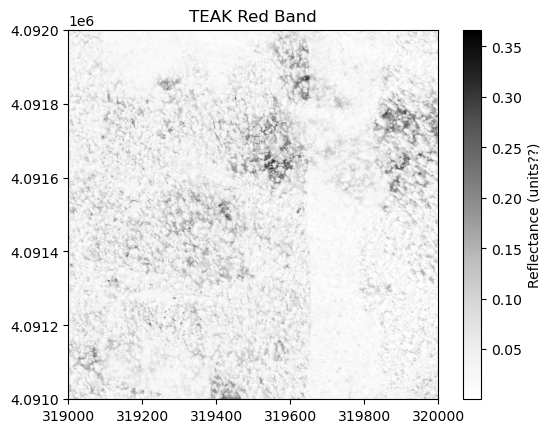

In [153]:
teak_plot = plt.imshow(RGB_bands[0],
                       extent=teak_extent,
                       cmap='Greys') 
cbar = plt.colorbar(); 
cbar.set_label('Reflectance (units??)');
plt.title('TEAK Red Band');


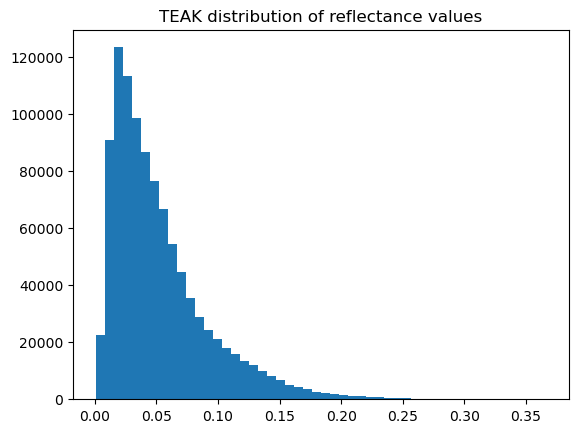

In [155]:
plt.hist(RGB_bands[0].flatten(), bins=50);
plt.title('TEAK distribution of reflectance values');

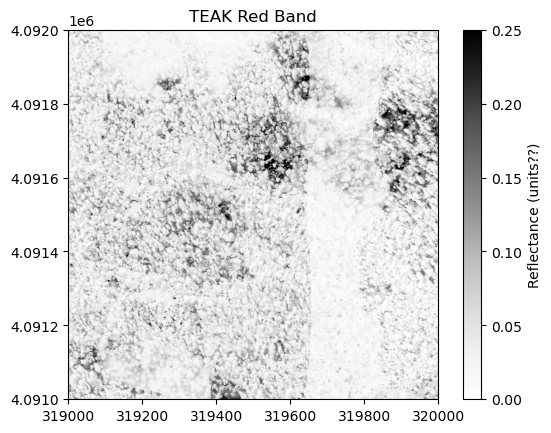

In [156]:
teak_plot = plt.imshow(RGB_bands[0],
                       extent=teak_extent,
                       cmap='Greys',
                       clim=(0,0.25)) # set limit based on hist to make image less washed out 
cbar = plt.colorbar(); 
cbar.set_label('Reflectance (units??)');
plt.title('TEAK Red Band');

In [146]:
# normalize bands to be on 0-1 scale
for band in RGB_bands:
    band *= 1/band.max() 
    
# convert to MxNx3 shape
RGB_bands_zipped = [tuple(zip(RGB_bands[0][row_index],RGB_bands[1][row_index],RGB_bands[2][row_index]))
                    for row_index in range(refl_shape[0])]

(1000, 1000, 426)
1000 1000 3
((0.04773595199127115, 0.08702337023370234, 0.0737030411449016), (0.04991816693944354, 0.06642066420664207, 0.07191413237924865), (0.03518821603927987, 0.07011070110701108, 0.05939177101967799), (0.03109656301145663, 0.07195571955719558, 0.05796064400715562), (0.039552645935624665, 0.06980319803198033, 0.06475849731663685), (0.043371522094926354, 0.06765067650676507, 0.0661896243291592), (0.03873431533006001, 0.07349323493234933, 0.06762075134168156), (0.034369885433715226, 0.07380073800738007, 0.06940966010733451), (0.034369885433715226, 0.07410824108241082, 0.0697674418604651))


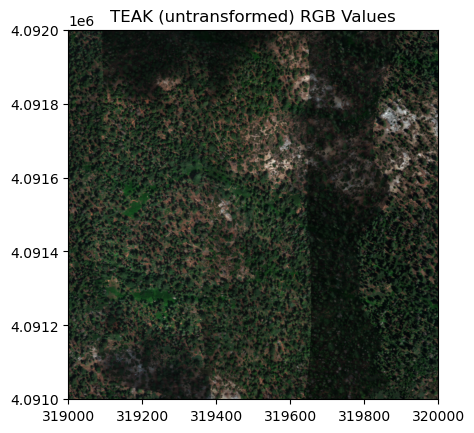

In [157]:
teak_plot = plt.imshow(RGB_bands_zipped, 
                       extent=teak_extent,
                       cmap='gist_earth')
plt.title('TEAK (untransformed) RGB Values');


My next steps will be to use the last part of the (NEON tutorial) [https://www.neonscience.org/resources/learning-hub/tutorials/neon-aop-hdf5-tile-py] to learn how about basic image processing